In [27]:
# import the necessary packages
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
from pyimagesearch.transform import four_point_transform
import dlib
import pytesseract
import cv2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


def display_image_in_actual_size(im_data):

    dpi = 80
    depth = 1
    if (len(im_data.shape) == 3):
        height, width,depth = im_data.shape
    else:
        height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [25]:
contours = []
img = []
img_y = []
img_x = []
def binaryze_and_threshold(image):
    global contours
    global img, img_y, img_x
    def ii(xx, yy):
        global img, img_y, img_x
        if yy >= img_y or xx >= img_x:
            return 0
        pixel = img[yy][xx]
        return 0.30 * pixel[2] + 0.59 * pixel[1] + 0.11 * pixel[0]


    # A quick test to check whether the contour is
    # a connected shape
    def connected(contour):
        first = contour[0][0]
        last = contour[len(contour) - 1][0]
        return abs(first[0] - last[0]) <= 1 and abs(first[1] - last[1]) <= 1


    # Helper function to return a given contour
    def c(index):
        global contours
        return contours[index]


    # Count the number of real children
    def count_children(index, h_, contour):
        # No children
        if h_[index][2] < 0:
            return 0
        else:
            #If the first child is a contour we care about
            # then count it, otherwise don't
            if keep(c(h_[index][2])):
                count = 1
            else:
                count = 0

                # Also count all of the child's siblings and their children
            count += count_siblings(h_[index][2], h_, contour, True)
            return count


    # Quick check to test if the contour is a child
    def is_child(index, h_):
        return get_parent(index, h_) > 0


    # Get the first parent of the contour that we care about
    def get_parent(index, h_):
        parent = h_[index][3]
        while not keep(c(parent)) and parent > 0:
            parent = h_[parent][3]

        return parent


    # Count the number of relevant siblings of a contour
    def count_siblings(index, h_, contour, inc_children=False):
        # Include the children if necessary
        if inc_children:
            count = count_children(index, h_, contour)
        else:
            count = 0

        # Look ahead
        p_ = h_[index][0]
        while p_ > 0:
            if keep(c(p_)):
                count += 1
            if inc_children:
                count += count_children(p_, h_, contour)
            p_ = h_[p_][0]

        # Look behind
        n = h_[index][1]
        while n > 0:
            if keep(c(n)):
                count += 1
            if inc_children:
                count += count_children(n, h_, contour)
            n = h_[n][1]
        return count


    # Whether we care about this contour
    def keep(contour):
        return keep_box(contour) and connected(contour)


    # Whether we should keep the containing box of this
    # contour based on it's shape
    def keep_box(contour):
        xx, yy, w_, h_ = cv2.boundingRect(contour)

        # width and height need to be floats
        w_ *= 1.0
        h_ *= 1.0

        # Test it's shape - if it's too oblong or tall it's
        # probably not a real character
        if w_ / h_ < 0.1 or w_ / h_ > 10:
            return False

        # check size of the box
        if ((w_ * h_) > ((img_x * img_y) / 5)) or ((w_ * h_) < 15):
            return False

        return True


    def include_box(index, h_, contour):

        if is_child(index, h_) and count_children(get_parent(index, h_), h_, contour) <= 2:
            return False

        if count_children(index, h_, contour) > 2:
            return False
        return True

    # Load the image
    orig_img = image

    # Add a border to the image for processing sake
    img = cv2.copyMakeBorder(orig_img, 50, 50, 50, 50, cv2.BORDER_CONSTANT)

    # Calculate the width and height of the image
    img_y = len(img)
    img_x = len(img[0])


    #Split out each channel
    blue, green, red = cv2.split(img)

    # Run canny edge detection on each channel
    blue_edges = cv2.Canny(blue, 200, 250)
    green_edges = cv2.Canny(green, 200, 250)
    red_edges = cv2.Canny(red, 200, 250)

    # Join edges back into image
    edges = blue_edges | green_edges | red_edges

    # Find the contours
    _, contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    hierarchy = hierarchy[0]


    # These are the boxes that we are determining
    keepers = []

    # For each contour, find the bounding rectangle and decide
    # if it's one we care about
    for index_, contour_ in enumerate(contours):

        x, y, w, h = cv2.boundingRect(contour_)

        # Check the contour and it's bounding box
        if keep(contour_) and include_box(index_, hierarchy, contour_):
            # It's a winner!
            keepers.append([contour_, [x, y, w, h]])
        else:
            pass

    # Make a white copy of our image
    new_image = edges.copy()
    new_image.fill(255)
    boxes = []

    # For each box, find the foreground and background intensities
    for index_, (contour_, box) in enumerate(keepers):

        # Find the average intensity of the edge pixels to
        # determine the foreground intensity
        fg_int = 0.0
        for p in contour_:
            fg_int += ii(p[0][0], p[0][1])

        fg_int /= len(contour_)

        # Find the intensity of three pixels going around the
        # outside of each corner of the bounding box to determine
        # the background intensity
        x_, y_, width, height = box
        bg_int = \
            [
                # bottom left corner 3 pixels
                ii(x_ - 1, y_ - 1),
                ii(x_ - 1, y_),
                ii(x_, y_ - 1),

                # bottom right corner 3 pixels
                ii(x_ + width + 1, y_ - 1),
                ii(x_ + width, y_ - 1),
                ii(x_ + width + 1, y_),

                # top left corner 3 pixels
                ii(x_ - 1, y_ + height + 1),
                ii(x_ - 1, y_ + height),
                ii(x_, y_ + height + 1),

                # top right corner 3 pixels
                ii(x_ + width + 1, y_ + height + 1),
                ii(x_ + width, y_ + height + 1),
                ii(x_ + width + 1, y_ + height)
            ]

        # Find the median of the background
        # pixels determined above
        bg_int = np.median(bg_int)


        # Determine if the box should be inverted
        if fg_int >= bg_int:
            fg = 255
            bg = 0
        else:
            fg = 0
            bg = 255

            # Loop through every pixel in the box and color the
            # pixel accordingly
        for x in range(x_, x_ + width):
            for y in range(y_, y_ + height):
                if y >= img_y or x >= img_x:
                    continue
                if ii(x, y) > fg_int:
                    new_image[y][x] = bg
                else:
                    new_image[y][x] = fg

    # blur a bit to improve ocr accuracy
    new_image = cv2.blur(new_image, (2, 2))
    return new_image

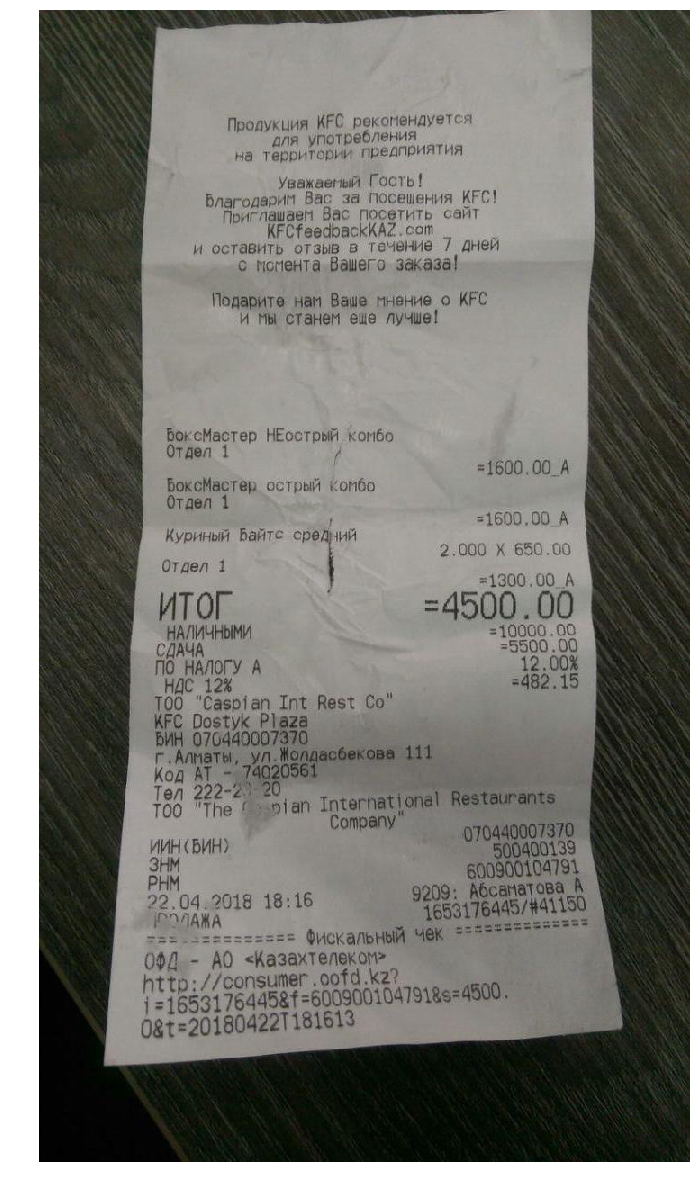

2484
!


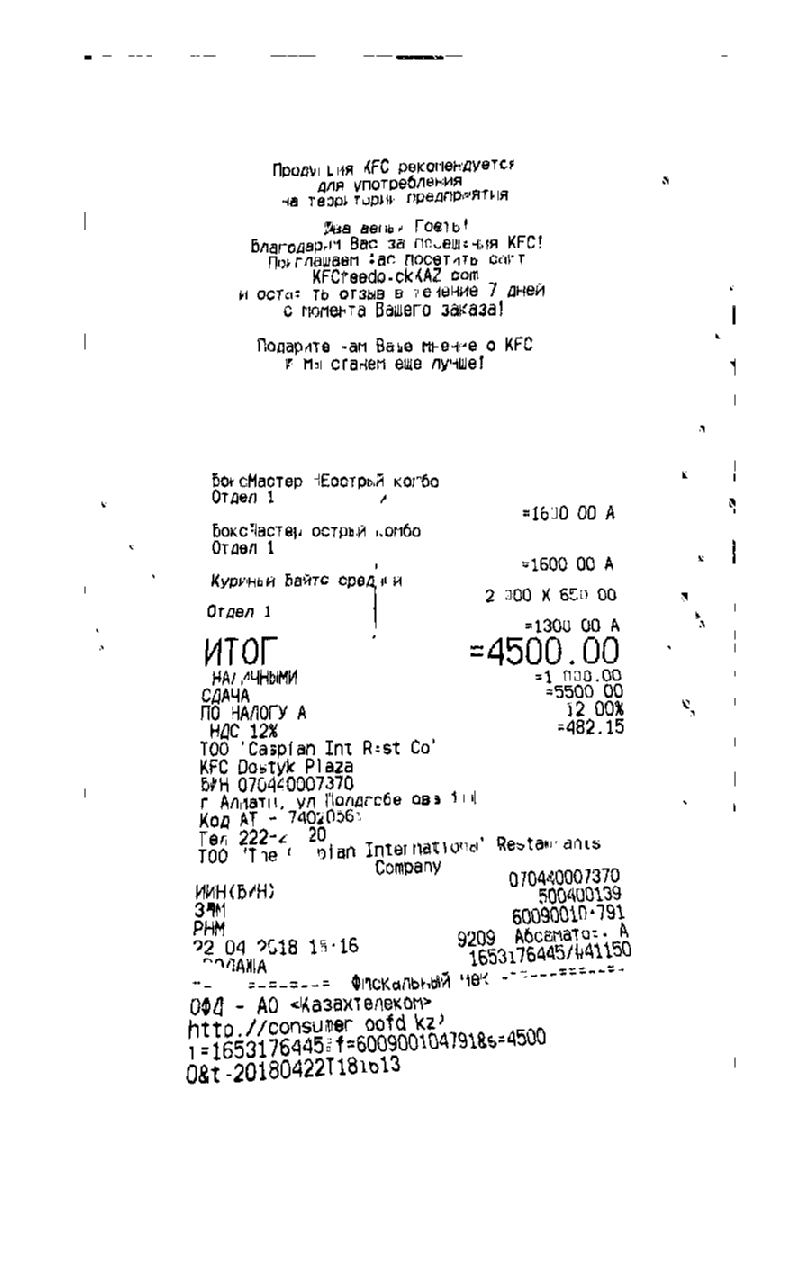

In [26]:
if __name__ == "__main__":
    orig = cv2.imread('img_tests/receipt9.jpg')
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    display_image_in_actual_size(orig)
    display_image_in_actual_size(binaryze_and_threshold(orig))